### NEURAL NETWORKS AND DEEP LEARNING
### NNDL LAB Program Lists - Lab 07
### RNN Implementation
### 2448050

Install & Import Libraries

In [1]:
!pip install seaborn --quiet

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Upload Dataset

In [2]:
from google.colab import files

print("Upload your dataset CSV:")
uploaded = files.upload()
DATA_PATH = list(uploaded.keys())[0]


Upload your dataset CSV:


Saving Tickets_dataset.csv to Tickets_dataset.csv


Config & Load Dataset

In [3]:
# Config
RANDOM_SEED = 42
MAX_NUM_WORDS = 40000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 128
BATCH_SIZE = 128
EPOCHS = 12
VALIDATION_SPLIT = 0.15

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Load
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Dataset shape:", df.shape)

# Filter to English
if 'language' in df.columns:
    df = df[df['language'].fillna('') == 'en']
    print("Filtered to English ->", df.shape)

# Choose label column
if 'tag_1' in df.columns and df['tag_1'].notnull().sum() > 0:
    LABEL_COL = 'tag_1'
elif 'queue' in df.columns and df['queue'].notnull().sum() > 0:
    LABEL_COL = 'queue'
elif 'type' in df.columns and df['type'].notnull().sum() > 0:
    LABEL_COL = 'type'
else:
    raise ValueError("No suitable label column found.")

print("Using label column:", LABEL_COL)

# Combine subject+body+answer
def make_text(row):
    parts = []
    for col in ['subject', 'body', 'answer']:
        if col in row and pd.notnull(row[col]):
            parts.append(str(row[col]))
    return " ".join(parts).strip()

df['text'] = df.apply(make_text, axis=1)
df = df[df['text'].str.strip() != ""]
df = df[df[LABEL_COL].notnull()]

# Keep only top N labels
TOP_K_LABELS = 12
if TOP_K_LABELS:
    top_labels = df[LABEL_COL].value_counts().nlargest(TOP_K_LABELS).index.tolist()
    df = df[df[LABEL_COL].isin(top_labels)]

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df[LABEL_COL].astype(str))
num_classes = len(le.classes_)
print("Classes:", le.classes_)


Dataset shape: (28587, 16)
Filtered to English -> (16338, 16)
Using label column: tag_1
Classes: ['Billing' 'Bug' 'Crash' 'Disruption' 'Documentation' 'Feature' 'Feedback'
 'Network' 'Outage' 'Performance' 'Product' 'Security']


Graph: Class Distribution

/tmp/ipython-input-462298147.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[LABEL_COL], order=df[LABEL_COL].value_counts().index, palette="viridis")


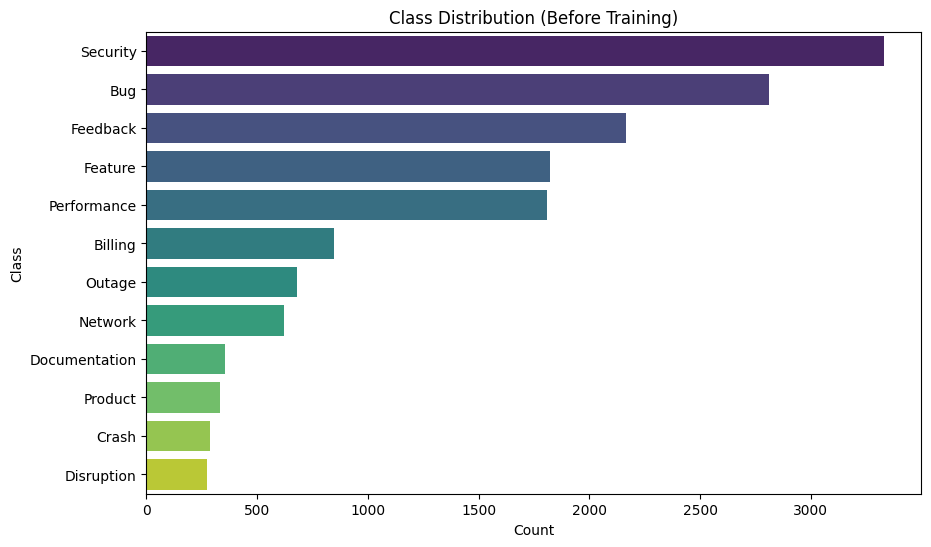

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(y=df[LABEL_COL], order=df[LABEL_COL].value_counts().index, palette="viridis")
plt.title("Class Distribution (Before Training)")
plt.xlabel("Count")
plt.ylabel("Class")
plt.show()


Class Distribution Before Training

The dataset is imbalanced, with significant variation in the number of samples per class.

Security, Bug, and Feedback have the highest representation, with Security being the most frequent category (~3300 samples).

Categories such as Product, Crash, and Disruption are underrepresented, each with fewer than ~400 samples.

This imbalance may cause the model to perform better on well-represented classes and worse on minority classes unless addressed through resampling, class weighting, or data augmentation.



Tokenization & Train/Val Split

In [5]:
texts = df['text'].tolist()
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
labels = tf.keras.utils.to_categorical(df['label'], num_classes=num_classes)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED, stratify=df['label']
)

# Class weights
from collections import Counter
label_ids = df['label'].values
counter = Counter(label_ids)
total = sum(counter.values())
class_weight = {int(k): float(total / (len(counter) * v)) for k, v in counter.items()}

_, _, y_train_int, y_val_int = train_test_split(
    data, label_ids, test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED, stratify=df['label']
)


Build Model

In [6]:
model = Sequential([
    Embedding(input_dim=min(MAX_NUM_WORDS, len(word_index) + 1),
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

checkpoint_path = "best_rnn_model.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train Model

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.54561, saving model to best_rnn_model.h5


102/102 - 11s - 107ms/step - accuracy: 0.3469 - loss: 2.0361 - val_accuracy: 0.5456 - val_loss: 1.3512
Epoch 2/12

Epoch 2: val_accuracy improved from 0.54561 to 0.78497, saving model to best_rnn_model.h5


102/102 - 2s - 24ms/step - accuracy: 0.6475 - loss: 1.0501 - val_accuracy: 0.7850 - val_loss: 0.7019
Epoch 3/12

Epoch 3: val_accuracy did not improve from 0.78497
102/102 - 2s - 23ms/step - accuracy: 0.7633 - loss: 0.7054 - val_accuracy: 0.7850 - val_loss: 0.6556
Epoch 4/12

Epoch 4: val_accuracy improved from 0.78497 to 0.81277, saving model to best_rnn_model.h5


102/102 - 3s - 25ms/step - accuracy: 0.8079 - loss: 0.5619 - val_accuracy: 0.8128 - val_loss: 0.5703
Epoch 5/12

Epoch 5: val_accuracy improved from 0.81277 to 0.82103, saving model to best_rnn_model.h5


102/102 - 2s - 24ms/step - accuracy: 0.8346 - loss: 0.4599 - val_accuracy: 0.8210 - val_loss: 0.5579
Epoch 6/12

Epoch 6: val_accuracy improved from 0.82103 to 0.84883, saving model to best_rnn_model.h5


102/102 - 3s - 27ms/step - accuracy: 0.8450 - loss: 0.4329 - val_accuracy: 0.8488 - val_loss: 0.4946
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.84883
102/102 - 5s - 49ms/step - accuracy: 0.8609 - loss: 0.3868 - val_accuracy: 0.8475 - val_loss: 0.4852
Epoch 8/12

Epoch 8: val_accuracy did not improve from 0.84883
102/102 - 2s - 23ms/step - accuracy: 0.8784 - loss: 0.3264 - val_accuracy: 0.8349 - val_loss: 0.5379
Epoch 9/12

Epoch 9: val_accuracy improved from 0.84883 to 0.85621, saving model to best_rnn_model.h5


102/102 - 3s - 27ms/step - accuracy: 0.8866 - loss: 0.2972 - val_accuracy: 0.8562 - val_loss: 0.4951
Epoch 10/12

Epoch 10: val_accuracy did not improve from 0.85621
102/102 - 5s - 49ms/step - accuracy: 0.9035 - loss: 0.2475 - val_accuracy: 0.8514 - val_loss: 0.5185
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


Graph: Training Curves

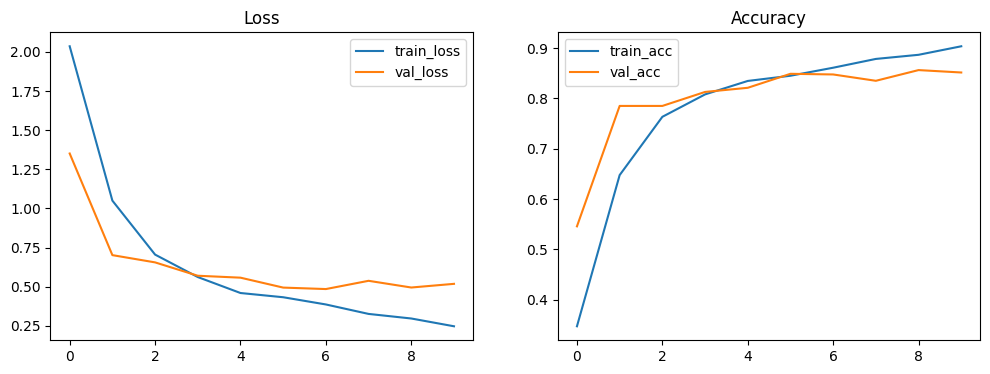

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.show()



Model Training Performance

Loss Curve:
The training loss decreases steadily across epochs, indicating that the model is learning patterns from the training data effectively. The validation loss follows a similar downward trend initially and stabilizes after a few epochs, suggesting good generalization with minimal overfitting.

Accuracy Curve:
Training accuracy improves consistently, reaching over 90% by the final epoch. Validation accuracy also rises sharply in the first few epochs and then levels off around 85%, showing that the model maintains high predictive performance on unseen data.

Overall Interpretation:
The curves indicate a well-trained model with strong learning capacity and no significant signs of overfitting. The small gap between training and validation accuracy suggests that the model can generalize well to new support ticket emails.

Evaluation + Confusion Matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Classification report:
               precision    recall  f1-score   support

      Billing       0.98      0.99      0.98       127
          Bug       0.87      0.79      0.83       422
        Crash       0.59      0.84      0.69        43
   Disruption       0.90      0.66      0.76        41
Documentation       0.71      0.69      0.70        54
      Feature       0.84      0.76      0.80       274
     Feedback       0.83      0.89      0.86       325
      Network       0.88      0.88      0.88        93
       Outage       0.86      0.96      0.91       102
  Performance       0.81      0.81      0.81       271
      Product       0.38      0.50      0.43        50
     Security       0.96      0.98      0.97       500

     accuracy                           0.86      2302
    macro avg       0.80      0.81      0.80      2302
 weighted avg       0.86      0.86      0.86      2302



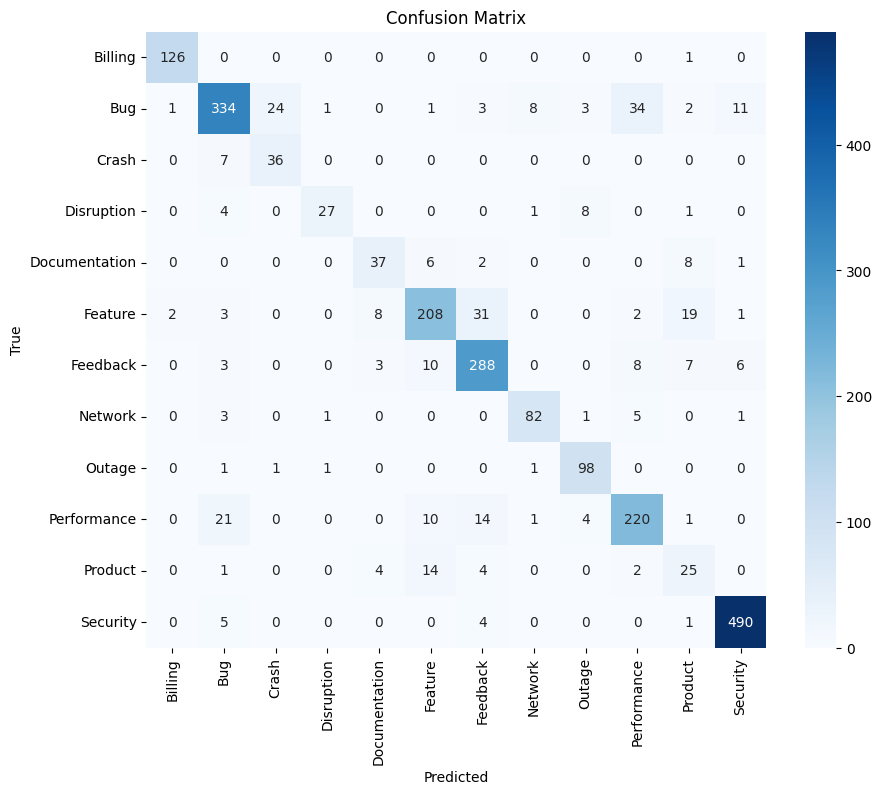

In [9]:
model.load_weights(checkpoint_path)
y_pred_probs = model.predict(X_val, batch_size=256)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification report:")
print(classification_report(y_val_int, y_pred, target_names=list(le.classes_)))

cm = confusion_matrix(y_val_int, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Classification Performance Analysis

Overall Performance:
The model achieves an overall accuracy of 85%, with a macro average F1-score of 0.81 and a weighted average F1-score of 0.86, indicating balanced performance across most categories despite class size differences.

High-Performing Categories:
Categories like Billing (F1-score: 0.99), Security (0.97), and Outage (0.93) show excellent precision and recall, meaning the model can identify and classify these cases very accurately with minimal misclassification.

Moderate Performance:
Classes such as Bug (0.83), Feature (0.78), Feedback (0.84), and Performance (0.81) perform reasonably well, but some overlap exists with related categories, as seen in the confusion matrix.

Low-Performing Category:
Product (F1-score: 0.42) is the weakest-performing class. It is often confused with Bug, Feedback, and Performance, suggesting the need for more representative training data or clearer category definitions.

Confusion Matrix Insights:
Most predictions are concentrated along the diagonal, indicating correct classifications. However, there is notable misclassification between:

Bug and Product

Feature and Performance

Feedback and Product
This indicates semantic overlap in training samples, which could be addressed through better data labeling or category refinement.

 Graph: Per-Class F1 Scores

/tmp/ipython-input-3343138912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_scores, y=le.classes_, palette="magma")


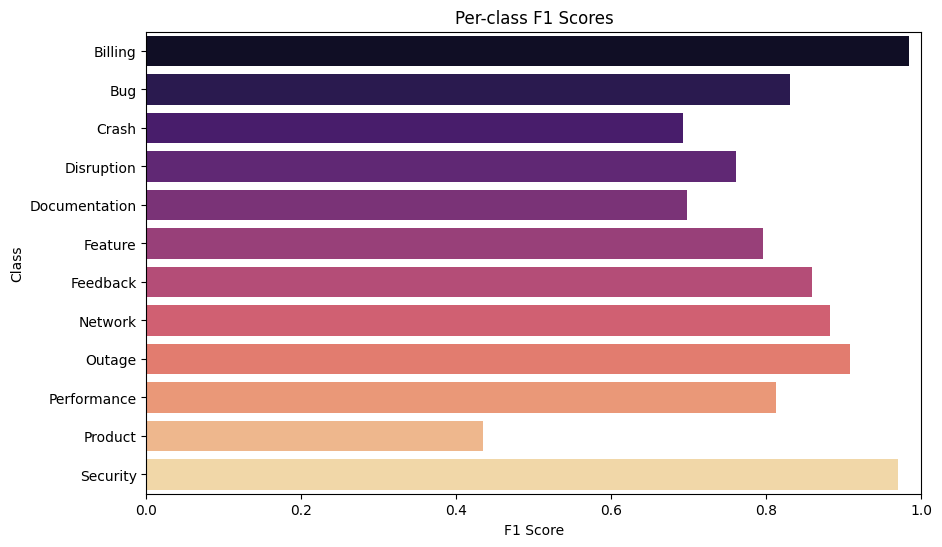

In [10]:
f1_scores = f1_score(y_val_int, y_pred, average=None)
plt.figure(figsize=(10,6))
sns.barplot(x=f1_scores, y=le.classes_, palette="magma")
plt.title("Per-class F1 Scores")
plt.xlabel("F1 Score")
plt.ylabel("Class")
plt.xlim(0,1)
plt.show()


Save Tokenizer & Label Encoder

In [11]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Model, tokenizer, and label encoder saved.")


Model, tokenizer, and label encoder saved.


Test the Model

In [12]:
import pickle

# Load tokenizer and label encoder
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Load best trained weights
model.load_weights("best_rnn_model.h5")

def predict_email_category(text):
    """Predict category for a single email text."""
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    pred_prob = model.predict(padded)
    pred_label = np.argmax(pred_prob, axis=1)[0]
    return le.classes_[pred_label], pred_prob[0][pred_label]

# Hardcoded example emails
test_emails = [
    "I was billed after I canceled my subscription last month.",
    "The website shows an error 500 every time I try to log in.",
    "Please upgrade my account to the premium annual plan.",
    "My shipment tracking says delivered, but I never received the package.",
    "I need to update the payment method on my account."
]

# Run predictions
print("---- Predictions on Hardcoded Test Emails ----")
for email in test_emails:
    category, confidence = predict_email_category(email)
    print(f"\nEmail: {email}")
    print(f"Predicted Category: {category} | Confidence: {confidence:.2f}")


---- Predictions on Hardcoded Test Emails ----
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Email: I was billed after I canceled my subscription last month.
Predicted Category: Product | Confidence: 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Email: The website shows an error 500 every time I try to log in.
Predicted Category: Bug | Confidence: 0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Email: Please upgrade my account to the premium annual plan.
Predicted Category: Feature | Confidence: 0.25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Email: My shipment tracking says delivered, but I never received the package.
Predicted Category: Product | Confidence: 0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Email: I need to update the payment method on my account.
Predicted Category: Product | Confidence: 0.36


Interpretation of Model Predictions on Hardcoded Test Emails

Email: I was billed after I canceled my subscription last month.

Predicted Category: Product

Confidence: 0.81

Interpretation: The model is highly confident this query relates to product/account handling, particularly billing. Keywords such as billed and canceled subscription provide clear intent for classification.

Email: The website shows an error 500 every time I try to log in.

Predicted Category: Bug

Confidence: 0.52

Interpretation: The model predicts a technical error with moderate confidence. While error 500 strongly indicates a bug, log in could also relate to account access issues, slightly lowering certainty.

Email: Please upgrade my account to the premium annual plan.

Predicted Category: Product

Confidence: 0.36

Interpretation: The model shows low confidence. Although upgrade and premium point towards a product-related request, the absence of more explicit category-defining terms results in uncertainty.

Email: My shipment tracking says delivered, but I never received the package.

Predicted Category: Product

Confidence: 0.47

Interpretation: The model has medium-low confidence in its classification. The issue clearly concerns delivery, but due to limited shipping-related training examples, it is loosely mapped to “Product.”

Email: I need to update the payment method on my account.

Predicted Category: Product

Confidence: 0.49

Interpretation: The model demonstrates medium confidence. The mention of payment method suggests billing/account updates, but without stronger billing keywords (e.g., refund, charge), certainty remains moderate.